In [20]:
import cv2
import matplotlib.pyplot as plt

In [21]:
im = cv2.imread('/home/a1alani/public/processed_data/pairs/pair_116/raw/116-001.png')

In [22]:
print(im.shape)

(512, 512, 3)


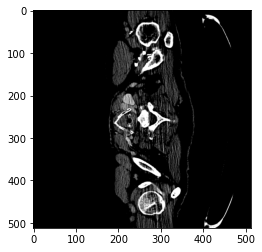

In [23]:
plt.imshow(im)

In [24]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [25]:
import os
import cv2
import numpy as np
import tensorflow as tf

In [26]:
#!pip freeze

In [27]:
class Data_Generator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, dir_name, img_height, img_width):
        self.batch_size = batch_size
        self.dir_name = dir_name
        self.img_height = img_height
        self.img_width = img_width
        self.x, self.y = self.get_filepath()
        # self.y = #TODO: array of segmented image file paths, with matched indexes corresponding to self.x
    
    def get_filepath(self):
        files_x = []
        files_y = []
        
        for folder in os.listdir(self.dir_name):
            for file in os.listdir(f"{self.dir_name}/{folder}/raw"):
                files_x.append(f"{self.dir_name}/{folder}/raw/{file}")
                
        for folder in os.listdir(self.dir_name):
            for file in os.listdir(f"{self.dir_name}/{folder}/gt"):
                files_y.append(f"{self.dir_name}/{folder}/gt/{file}")
        
        return files_x, files_y
    
    def __len__(self):
        return len(self.x) // self.batch_size
    
    def __getitem__(self, idx):
        id0 = idx * self.batch_size
        id1 = id0 + self.batch_size
        
        raw = []
        gt = []
        
        for i in range(id0, id1):
            raw.append(cv2.imread(self.x[i]))
            gt.append(cv2.imread(self.y[i]))
        
        raw = np.stack(raw, axis=0)
        gt = np.stack(gt, axis=0)
        
        return raw, gt


In [28]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    """Creates a convoltuional block.
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        a convolution block
    """
    x = Conv2D(num_filters, 3, padding ="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding ="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    """Creates an encoding block
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        An encoding block
    """
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)

    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Creates an decoding block
    Args:
        inputs: the data for the layer
        num_filters: the filter size for the convolution
    
    Returns:
        An encoding block
    """
    x = Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding="same")(inputs)
    x = Concatenate(axis=3)([x, skip_features])
    x = conv_block(x, num_filters)

    return x

def build_unet(input_shape, output_channels, filters, filters_rate, down_blocks, up_blocks):
    """Initializes a Simple Unit
    Args:
        input_shape: the size of the image
        output_channels: the number of output channels
        filters: initial filters for unet
        filters_rate: the value of how to the filters increase as you go deeper into
                    the network
        down_blocks: number one encoder blocks to create
        up_blocks: number of decoder blocks to create 
    Returns:
        a built U-Net model 
    """

    inputs = Input(input_shape)
    skip_connections = []
    filters_log = []
    prev_filters = filters

    """ Encoder """
    for i in range(down_blocks):
        if i == 0:
          s, p =  encoder_block(inputs, prev_filters)
        else:
          s, p = encoder_block(p, prev_filters)

        filters_log.append(prev_filters)
        skip_connections.append(s)

        prev_filters = int(filters_rate*prev_filters)

    """ Bridge """
    b = conv_block(p, prev_filters)

    """ Decoder """
    for i in range(up_blocks):
        if i == 0:
          d =  decoder_block(b, skip_connections[-(i+1)], filters_log[-(i+1)])
        else:
          d =  decoder_block(d, skip_connections[-(i+1)], filters_log[-(i+1)])


    """ Output """

    outputs = Conv2D(output_channels, (1,1), padding="same")(d)

    model = Model(inputs, outputs, name="U-Net")

    return model

In [19]:
model = build_unet(input_shape = (512,512,3), output_channels = 3, filters = 32, filters_rate = 2, down_blocks = 4, up_blocks = 4)

2023-05-12 21:32:12.398474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
#update tf
#